Simulação aplicando diferentes metodos para a filtragem do ruído, no código abaixo simulamos o sinal base com PPC pontos por oscilação e tendo um comprimento de N pontos.

In [1]:
from pylab import *
from scipy.signal import sawtooth

In [2]:
#funções referentes as simulações
def geraSinal(amp, fase, PPC, NC):
    """ retorna o sinal x
           amplitude amp
           fase fase
           pontos por ciclo PPC
           número de ciclos NC
    """
    f = 1 # frequencia do sinal 1Hz
    Fs = f * PPC # Taxa de amostragem
    w = f / Fs   # frequencia digital
    N = NC * PPC # numero total de pontos (tempo total da simulação)
    n = np.arange(N)   # eixo n (tempo)
    # Sinal de entrada sem ruído
    x = amp * cos(2 * pi * w * n + fase)   # sinal de entrada
    return x

def geraSinalVar(amp_inicial, amp_final, fase, PPC, NC, NV):
    f = 1  # frequência do sinal 1 Hz
    Fs = f * PPC  # taxa de amostragem
    w = f / Fs    # frequência digital
    N_total = NC * PPC  # número total de pontos

    n = np.arange(N_total)
    amplitude = np.zeros(N_total)

    for i in range(N_total):
        ciclo_atual = i // (NV * PPC)
        if ciclo_atual % 2 == 0:
            amplitude[i] = amp_inicial
        else:
            amplitude[i] = amp_final

    Sn = amplitude * np.cos(2 * np.pi * w * n + fase)

    return Sn, amplitude


def LIAN(x, f, Fs):

    # Amostragem
    Sratio = Fs / (4 * f)
    o = arange(len(x) / Sratio) * Sratio
    o = o.astype(int)  # Garante que os índices sejam inteiros

    # Amostras In-phase e Quadratura
    oI, oQ = o[::2], o[1::2]
def LIAN(x, f, Fs):

    # Amostragem
    Sratio = Fs / (4 * f)
    o = arange(len(x) / Sratio) * Sratio
    o = o.astype(int)  # Garante que os índices sejam inteiros

    # Amostras In-phase e Quadratura
    oI, oQ = o[::2], o[1::2]

    # Processamento dos ciclos
    VI = (x[oI[:-1:2]] - x[oI[1::2]]) / 2
    VQ = -(x[oQ[:-1:2]] - x[oQ[1::2]]) / 2

    # Resultado complexo médio
    y = mean(VI) + 1j * mean(VQ)

    return y
    # Processamento dos ciclos
    VI = (x[oI[:-1:2]] - x[oI[1::2]]) / 2
    VQ = -(x[oQ[:-1:2]] - x[oQ[1::2]]) / 2

    # Resultado complexo médio
    y = mean(VI) + 1j * mean(VQ)

    return y


def LIAF(x, f, Fs):
    """
    Lock-in amplifier via método DFT/FFT.
    """
    N = len(x)
    X = fft(x) / N
    bin = int(N * f / Fs)
    y = 2 * X[bin]
    return y


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.abs(y_true) - np.abs(y_pred)) ** 2))

def LIACN(x, f, Fs):
    PPC = int(Fs / f)  # Pontos por ciclo
    N = len(x)  # Número total de pontos no sinal
    num_ciclos = N // PPC  # Número de ciclos completos no sinal

    # Reduzir o sinal para um número inteiro de ciclos
    x = x[:num_ciclos * PPC]

    # Inicializar variáveis para armazenar as médias
    VI_total = 0
    VQ_total = 0

    # Processar cada ciclo usando LIAN
    for i in range(num_ciclos):
        ciclo = x[i * PPC:(i + 1) * PPC]
        y = LIAN(ciclo, f, Fs)

        # Acumular as médias separadas de parte real (VI) e imaginária (VQ)
        VI_total += np.real(y)
        VQ_total += np.imag(y)

    # Calcular a média final
    VI_mean = VI_total / num_ciclos
    VQ_mean = VQ_total / num_ciclos

    # Resultado complexo médio
    y_final = VI_mean + 1j * VQ_mean

    return y_final

def LIACF(x, f, Fs):
    PPC = int(Fs / f)  # Pontos por ciclo
    N = len(x)  # Número total de pontos no sinal
    num_ciclos = N // PPC  # Número de ciclos completos no sinal

    # Reduzir o sinal para um número inteiro de ciclos
    x = x[:num_ciclos * PPC]

    # Inicializar variáveis para armazenar as médias
    VI_total = 0
    VQ_total = 0

    # Processar cada ciclo usando LIAN
    for i in range(num_ciclos):
        ciclo = x[i * PPC:(i + 1) * PPC]
        y = LIAF(ciclo, f, Fs)

        # Acumular as médias separadas de parte real (VI) e imaginária (VQ)
        VI_total += np.real(y)
        VQ_total += np.imag(y)

    # Calcular a média final
    VI_mean = VI_total / num_ciclos
    VQ_mean = VQ_total / num_ciclos

    # Resultado complexo médio
    y_final = VI_mean + 1j * VQ_mean

    return y_final

import numpy as np

def LIAN8(x, f, Fs):
    """
    Versão adaptada do método LIAN8 para qualquer PPC.
    Utiliza 8 amostras igualmente espaçadas em um ciclo do sinal.
    """
    PPC = int(Fs / f)  # Pontos por ciclo

    if PPC < 8:
        raise ValueError("PPC (Fs/f) deve ser pelo menos 8 para usar o LIAN8.")

    # Pegamos apenas os primeiros 8 pontos igualmente espaçados dentro de 1 ciclo
    indices = np.linspace(0, PPC - 1, 8, endpoint=True).astype(int)
    amostras = x[indices]

    # Associações como no método original
    Va, Va_, Vb, Vb_, Vc, Vc_, Vd, Vd_ = amostras

    # Diferenças
    Vi = Va - Vc
    Vo = Vb - Vd
    Vi_ = Va_ - Vc_
    Vo_ = Vb_ - Vd_

    # Componentes complexas
    V = Vi + 1j * Vo
    V_ = Vi_ + 1j * Vo_

    # Fator de rotação de 45°
    rotacao = np.exp(1j * np.pi / 4)

    # Resultado final
    Vt = (V + rotacao * V_) / 4

    return Vt

def LIAN12(x, f, Fs):
    """
    Versão adaptada do método LIAN12 para qualquer PPC.
    Utiliza 12 amostras igualmente espaçadas em um ciclo do sinal.
    """
    PPC = int(Fs / f)  # Pontos por ciclo

    if PPC < 12:
        raise ValueError("PPC (Fs/f) deve ser pelo menos 12 para usar o LIAN12.")

    # Pega 12 pontos igualmente espaçados dentro de 1 ciclo
    indices = np.linspace(0, PPC - 1, 12, endpoint=True).astype(int)
    amostras = x[indices]

    # Separa em dois grupos defasados de 180° (como 6 pares)
    V = []
    for k in range(6):
        Vi = amostras[k] - amostras[k + 6]  # defasados de 180°
        angulo = k * np.pi / 6  # 30° por par
        V.append(Vi * np.exp(1j * angulo))  # aplica rotação

    Vt = np.mean(V)  # média final complexa

    return Vt
def LIANEWMA(x, f, Fs, alpha=0.9):

    PPC = int(Fs / f)  # Pontos por ciclo
    N = len(x)         # Número total de pontos no sinal
    num_ciclos = N // PPC  # Número de ciclos completos no sinal

    if num_ciclos == 0: #
        return 0 + 0j # Retorna zero caso não hajam ciclos completos

    x = x[:num_ciclos * PPC] # Reduz o sinal a um número inteiro de ciclos

    ewma_estimates_per_cycle = [] # Lista temporária para armazenar as estimativas EWMA de cada ciclo

    ewma_real = 0
    ewma_imag = 0

    for i in range(num_ciclos): # Processar cada ciclo com o LIAN e aplicar o EWMA
        ciclo = x[i * PPC:(i + 1) * PPC] #

        y_lian_cycle = LIAN(ciclo, f, Fs) # Calcula o LIAN para o ciclo atual

        # Aplica o EWMA
        if i == 0: #
            ewma_real = np.real(y_lian_cycle) #
            ewma_imag = np.imag(y_lian_cycle) #
        else:
            ewma_real = (1 - alpha) * np.real(y_lian_cycle) + alpha * ewma_real
            ewma_imag = (1 - alpha) * np.imag(y_lian_cycle) + alpha * ewma_imag

        # Adiciona a estimativa EWMA (complexa) para o ciclo atual à lista temporária
        ewma_estimates_per_cycle.append(ewma_real + 1j * ewma_imag)


    y_final = np.mean(ewma_estimates_per_cycle)

    return y_final

def gera_onda_triangular(amplitude=1.0, frequencia=1.0, duracao=1.0, taxa_amostragem=1000, fase=0):

    # 1. Cria um vetor de tempo, do início ao fim da duração desejada
    n_pontos = int(duracao * taxa_amostragem)
    t = np.linspace(0, duracao, n_pontos, endpoint=False)

    # 2. Gera a onda dente de serra com 'width=0.5' para criar uma forma triangular.
    # A saída da função sawtooth varia de -1 a 1.
    onda_base = sawtooth(2 * np.pi * frequencia * t + fase, width=0.5)

    # 3. Ajusta a amplitude da onda para o valor desejado
    onda = amplitude * onda_base

    return t, onda

In [3]:
# Parâmetros da simulação
PPC = 4 # pontos por ciclo
NC = 1  #  numero de ciclos completos
N = NC * PPC # numero total de pontos (tempo total da simulação)
f = 1 # frequencia do sinal
Fs = f * PPC # Taxa de amostragem
Fs_8 = f * 8
N_8 = 8* NC
N_12 = 12*NC
N_10 = 10* NC
Fs_12 = 12 * f

# Sinal de entrada sem ruído
amp = 1 # amplitude do sinal de teste
fase = 0  # fase fo sinal de teste
w = f / Fs   # frequencia digital
n = np.arange(N)   # eixo n (tempo)
n_8 = np.arange(N_8)
# Gerando sinal
x= geraSinal(amp,fase, PPC, NC)

x10 = geraSinal(amp,fase, 10 , NC)

# Gerando Sinal com 8 pontos por ciclo
x_8 = geraSinal(amp,fase,8,NC)

# Gerando Sinal com 12 pontos por ciclo
x_12 = geraSinal(amp,fase,12,NC)

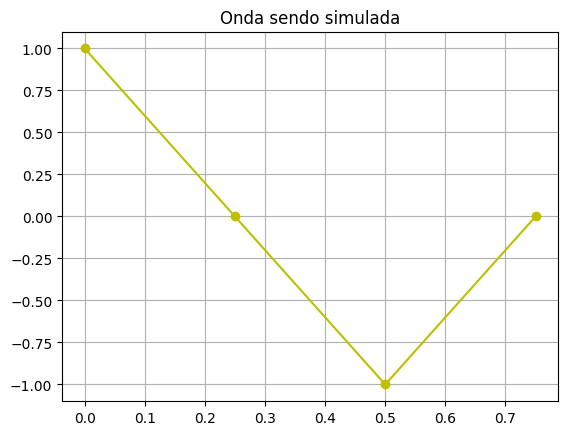

In [4]:
# Plotando o grafico
plt.plot(n / Fs, x,"o-", color='y')
#plt.plot(n_8 / Fs, x_8,"o-", color='r')
plt.title("Onda sendo simulada")
plt.grid(True)
plt.show()

Abaixo foi realizada a simulação do aumento do erro da amplitude com o aumento do ruído no sinal, foram aplicados 6 métodos no total, o sinal gerado tem amplitude de 1, e o ruído foi de 0 a 0.5, com incremento de 0.1, notamos como em geral o método de fourier é mais robusto para redução do ruído, o método LIACF é mais eficiente do que o método de fourier comum.

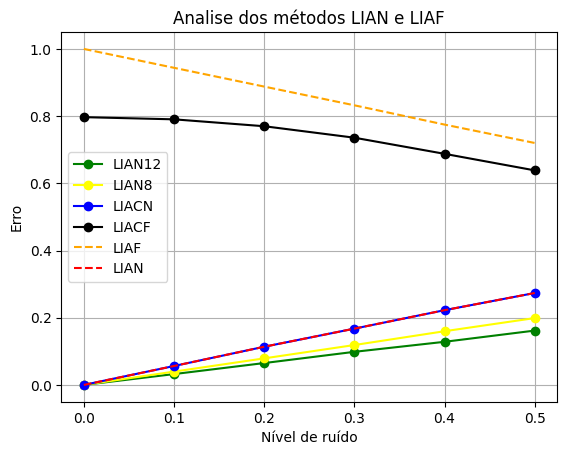

In [5]:
# Testar diferentes intensidades de ruído em relação à amplitude do sinal
ruidos_dp = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])
T = 10000 # número de simulações para calcular IC
eam = []

# Simula LIAN e LIAF
for dpr in ruidos_dp:
    erroabs = []
    for _ in range(T):
        r = np.random.normal(0, dpr, N)
        r_8 = np.random.normal(0, dpr, N_8)
        r_12 = np.random.normal(0,dpr,N_12)
        r_10 = np.random.normal(0,dpr,N_10)
        xr = x + r
        xr10 = x10 + r_10
        xr_8 = x_8 + r_8
        xr_12 = x_12 + r_12
        yn = LIAN(xr, f, Fs)
        yf = LIAF(xr10, f, Fs)
        ycn = LIACN(xr, f, Fs)
        ycf = LIACF(xr10, f, Fs)
        y8 = LIAN8(xr_8, f,Fs_8)
        y12 = LIAN12(xr_12,f, Fs_12)

        # Calcula o erro absoluto para cada método e armazena como tupla
        erroabs.append([rmse(yn, amp), rmse(yf, amp), rmse(ycn,amp), rmse(ycf, amp), rmse(y8, amp), rmse(y12,amp)])

    eam.append(np.mean(erroabs, axis=0))

# Convertendo para erro relativo
em = array(eam) / amp

# Plotagem
rsd = ruidos_dp
plt.plot(rsd, em[:, 5], '-o', label='LIAN12',color = "green")
plt.plot(rsd, em[:, 4], '-o', label='LIAN8',color = "yellow")
plt.plot(rsd, em[:, 2], '-o', label='LIACN',color = "blue")
plt.plot(rsd, em[:, 3], '-o', label='LIACF',color = "black")
plt.plot(rsd, em[:, 1], '--', label='LIAF', color = "orange")
plt.plot(rsd, em[:, 0], '--', label='LIAN', color = "red")

plt.xlabel('Nível de ruído')
plt.ylabel('Erro')
plt.legend()
plt.title("Analise dos métodos LIAN e LIAF")
plt.grid(True)
plt.show()


Abaixo foi feita uma simulação variando o numero de pontos por ciclo do sinal, definimos os PPC desejados no PPC_array, após isto realizamos os ajustes necessarios dos parametros e executamos a função LIAN e LIAF, é possível perceber que conforme aumentamos os pontos por ciclo o método de fourier fica melhor em suprimir o ruído.

/tmp/ipython-input-4068810880.py:32: RuntimeWarning: Mean of empty slice
  erroabs_N.append(np.nanmean(eam_2, axis=0))


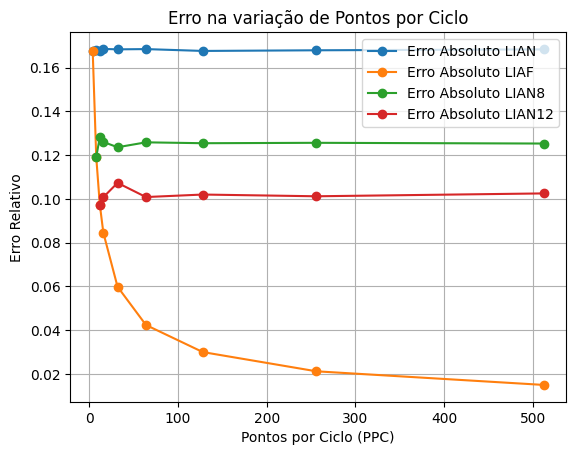

In [ ]:
amp = 1
fase = 0
NC = 1
f = 1

PPC_array = np.array([4, 8, 12, 16, 32, 64, 128, 256, 512])
erroabs_N = []
T = 100000

for PPC in PPC_array:
    eam_2 = []
    for _ in range(T):
        x = geraSinal(amp, fase, PPC, NC)
        r = np.random.normal(0, 0.3, len(x))
        xr = x + r

        erro_lian = rmse(np.abs(LIAN(xr, f, PPC)), amp)
        erro_liaf = rmse(np.abs(LIAF(xr, f, PPC)), amp)

        if PPC >= 8:
            erro_lian8 = rmse(np.abs(LIAN8(xr, f, PPC)), amp)
        else:
            erro_lian8 = np.nan

        if PPC >= 12:
            erro_lian12 = rmse(np.abs(LIAN12(xr, f, PPC)), amp)
        else:
            erro_lian12 = np.nan

        eam_2.append((erro_lian, erro_liaf, erro_lian8, erro_lian12))

    erroabs_N.append(np.nanmean(eam_2, axis=0))

erroabs_N = np.array(erroabs_N)

# Plotagem
plt.plot(PPC_array, erroabs_N[:, 0], "o-", label="Erro Absoluto LIAN")
plt.plot(PPC_array, erroabs_N[:, 1], "o-", label="Erro Absoluto LIAF")

mask8 = PPC_array >= 8
plt.plot(PPC_array[mask8], erroabs_N[mask8, 2], "o-", label="Erro Absoluto LIAN8")

mask12 = PPC_array >= 12
plt.plot(PPC_array[mask12], erroabs_N[mask12, 3], "o-", label="Erro Absoluto LIAN12")

plt.xlabel("Pontos por Ciclo (PPC)")
plt.ylabel("Erro Relativo")
plt.legend()
plt.title("Erro na variação de Pontos por Ciclo")
plt.grid(True)
plt.show()


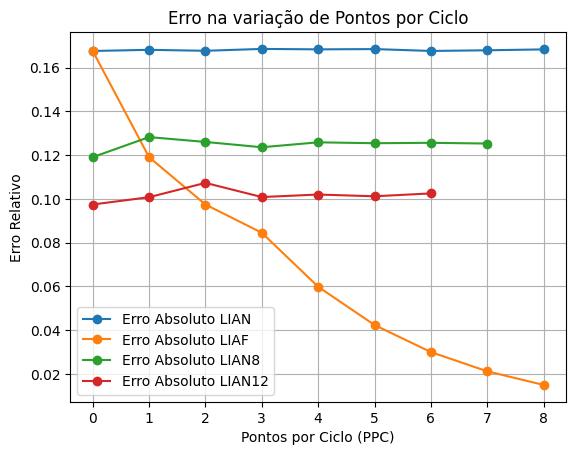

In [ ]:
# Plotagem
plt.plot( erroabs_N[:, 0], "o-", label="Erro Absoluto LIAN")
plt.plot( erroabs_N[:, 1], "o-", label="Erro Absoluto LIAF")

mask8 = PPC_array >= 8
plt.plot(erroabs_N[mask8, 2], "o-", label="Erro Absoluto LIAN8")

mask12 = PPC_array >= 12
plt.plot(erroabs_N[mask12, 3], "o-", label="Erro Absoluto LIAN12")

plt.xlabel("Pontos por Ciclo (PPC)")
plt.ylabel("Erro Relativo")
plt.legend()
plt.title("Erro na variação de Pontos por Ciclo")
plt.grid(True)
plt.show()


Abaixo foi feito a simulação de diversas ondas similares variando unicamente o numero de ciclos da onda, como é feita a média a cada ciclo conforme aumentamos o numero de cilcos o erro estabiliza.

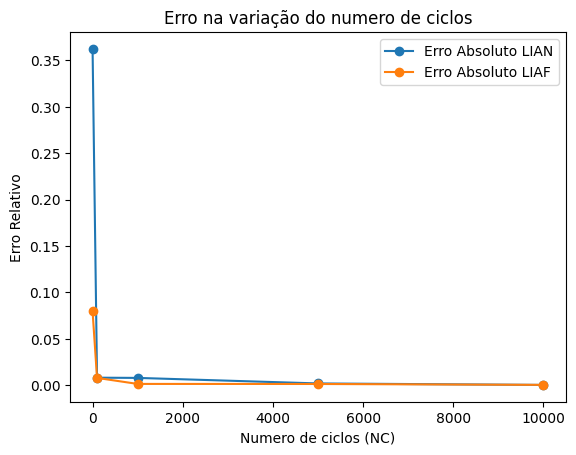

In [ ]:
# Array com os numeros de ciclos desejados
NC_array = array([1, 100, 1000, 5000, 10000,])
erroabs_NC = []
PPC = 16

for NC in NC_array:
    N = PPC * NC
    x =  geraSinal(amp, fase, PPC, NC)
    r = np.random.normal(0, 0.3, N)
    xr_3 = x + r
    # aplicando as funções
    yn_3 = LIAN(xr_3, f, PPC)
    yf_3 = LIAF(xr_3, f, PPC)
    erroabs_NC.append((rmse(yn_3,amp),rmse(yf_3,amp)))

# Convertendo erroabs_N para um array NumPy
erroabs_NC = array(erroabs_NC)

# Plotando
plt.plot(NC_array, erroabs_NC[:, 0],"o-", label="Erro Absoluto LIAN")
plt.plot(NC_array, erroabs_NC[:, 1],"o-", label="Erro Absoluto LIAF")
plt.xlabel("Numero de ciclos (NC)")
plt.ylabel("Erro Relativo")
plt.legend()
plt.title("Erro na variação do numero de ciclos")
plt.show()

Abaixo foi realizada a simulação de varios sinais com diferentes pontos por ciclo (PPC), e plotamos o erro em relaçao a variação do ruído, tambem foi aplicado os dois diferentes métodos LIAN(N)  e LIAF(F)

In [ ]:
# Parâmetros da simulação
PPC_f = 10 # pontos por ciclo para o fourier
PPC_n = 4 #pontos por ciclo para o nyquist
NC = 10 #  numero de ciclos completos
N_f = NC * PPC_f # numero total de pontos (tempo total da simulação)
N_n = NC * PPC_n # numero total de pontos (tempo total da simulação)
f = 1000 # frequencia do sinal
Fs_f = f * PPC_f # Taxa de amostragem
Fs_n = f * PPC_n # Taxa de amostragem
NV = f * 0.1   #numero de ciclios em cada janela de medição


# Sinal de entrada sem ruído
amp = 1 # amplitude do sinal de teste
fase = 0  # fase fo sinal de teste
w_f = f / Fs_f   # frequencia digital
w_n = f / Fs_n
n_f = np.arange(2 * N_f)   # eixo n (tempo)
n_n = np.arange(2 * N_n)   # eixo n (tempo)

# Gerando sinal
x = geraSinalVar(1,2,fase, PPC_f, NC, NV)
n = np.arange(len(x))  # agora n tem o mesmo tamanho que x

In [ ]:

# Parâmetros da simulação
PPC_f = 10  # pontos por ciclo para o Fourier
PPC_n = 4   # pontos por ciclo para o Nyquist
NC = 12000    # numero de ciclos completos
N_f = NC * PPC_f
N_n = NC * PPC_n

# --- MUDANÇA 1: Renomear a variável de frequência de 'f' para 'freq_sinal' ---
freq_sinal = 1000  # frequência do sinal

# Atualizar as variáveis que dependiam de 'f'
Fs_f = freq_sinal * PPC_f  # Taxa de amostragem
Fs_n = freq_sinal * PPC_n  # Taxa de amostragem
NV = freq_sinal * 0.1      # numero de ciclos em cada janela de medição

# O resto do seu código de simulação
ruidos_dp = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
T = 100

# Gerar sinais com amplitude variável
x_f, amp_f = geraSinalVar(1, 2, fase, PPC_f, NC, NV)
x_n, amp_n = geraSinalVar(1, 2, fase, PPC_n, NC, NV)

NLA = np.array([0,0.01, 0.025, 0.035,0.045,0.055])
DFT = np.array([0,0.005,0.015,0.02,0.025,0.035])
Noise= np.array([0,0.2,0.4,0.6,0.8,1.0])

# Cálculo de erro
eam = []
for dpr in ruidos_dp:
    erroabs_lista = []
    for _ in range(T):
        r_f = np.random.normal(0, dpr, len(x_f))
        r_n = np.random.normal(0, dpr, len(x_n))
        xr_f = x_f + r_f
        xr_n = x_n + r_n

        # aplica o LIA ciclo a ciclo e armazena
        est_n = [LIAN(xr_n[i*PPC_n:(i+1)*PPC_n], freq_sinal, Fs_n) for i in range(len(x_n)//PPC_n)]
        est_f = [LIAF(xr_f[i*PPC_f:(i+1)*PPC_f], freq_sinal, Fs_f) for i in range(len(x_f)//PPC_f)]
        est_cn = [LIAN(xr_n[i*PPC_n:(i+1)*PPC_n], freq_sinal, Fs_n) for i in range(len(x_n)//PPC_n)]
        est_cf = [LIAF(xr_f[i*PPC_f:(i+1)*PPC_f], freq_sinal, Fs_f) for i in range(len(x_f)//PPC_f)]
        est_ewma = [LIANEWMA(xr_n[i*PPC_n:(i+1)*PPC_n], freq_sinal, Fs_n, alpha=0.3) for i in range(len(x_f)//PPC_f)]
        # Calcular EWMA para o sinal baseado em Nyquist (xr_n)


        # Gera a referência de amplitude para cada ciclo
        ref_amp_n = [np.mean(amp_n[i*PPC_n:(i+1)*PPC_n]) for i in range(len(x_n)//PPC_n)]
        ref_amp_f = [np.mean(amp_f[i*PPC_f:(i+1)*PPC_f]) for i in range(len(x_f)//PPC_f)]

        # Erros absolutos (RMSE) para esta iteração
        # Para est_ewma_n e est_ewma_f, como retornam um único valor,
        # comparamos com a média das amplitudes reais.
        erroabs_lista.append([
            rmse(est_n, ref_amp_n),
            rmse(est_f, ref_amp_f),
            rmse(est_cn, ref_amp_n),
            rmse(est_cf, ref_amp_f),
            rmse(est_ewma, ref_amp_n)
        ])

    # Média dos erros absolutos após T simulações
    eam.append(np.mean(erroabs_lista, axis=0))

# Converte a lista de médias para um array numpy
em_absoluto = np.array(eam)

# Calculo das amplitudes médias
ref_amp_media_f = np.mean(amp_f)
ref_amp_media_n = np.mean(amp_n)

# Calculo do erro relativo
em_relativo_f = (em_absoluto[:, 1] / ref_amp_media_f)/10
em_relativo_n = (em_absoluto[:, 0] / ref_amp_media_n)/10
em_relativo_cn = (em_absoluto[:, 2] / ref_amp_media_n)/10
em_relativo_cf = (em_absoluto[:, 3] / ref_amp_media_f)/10
em_relativo_ewma_n = (em_absoluto[:, 4] / ref_amp_media_n)/10


# Plotagem
rsd = ruidos_dp
# plotando erro relativo
plt.plot(rsd, em_relativo_cn, '-o', label='LIACN', color="blue")
plt.plot(rsd, em_relativo_cf, '-o', label='LIACF', color="black")
plt.plot(rsd, em_relativo_f, '--', label='LIAF', color="orange")
plt.plot(rsd, em_relativo_n, '--', label='LIAN', color="red")
plt.plot(rsd, em_relativo_ewma_n, '-x', label='LIANEWMA', color="green")
plt.plot(Noise, NLA,label='NLA')
plt.plot(Noise, DFT, label='DFT')


plt.xlabel('Nível de ruído (desvio padrão)')
plt.ylabel('Erro Relativo (RMSE)')
plt.title("Análise dos métodos LIAN e LIAF com EWMA com amplitude variável")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:

    # Parâmetros para a nossa onda de exemplo
    AMP_EXEMPLO = 1.0       # Amplitude de 3.0 V
    FREQ_EXEMPLO = 2.0     # 2 ciclos por segundo (2 Hz)
    DURACAO_EXEMPLO = 2.0   # Gerar 2 segundos de sinal
    TAXA_AMOSTRAGEM = 32   # 500 amostras por segundo

    # Chama a função para gerar a onda
    tempo, onda_triangular = gera_onda_triangular(
        amplitude=AMP_EXEMPLO,
        frequencia=FREQ_EXEMPLO,
        duracao=DURACAO_EXEMPLO,
        taxa_amostragem=TAXA_AMOSTRAGEM
    )

    # --- Plotar o resultado para verificação ---
    plt.figure(figsize=(10, 5))
    plt.plot(tempo, onda_triangular)
    plt.title('Exemplo de Onda Triangular Gerada')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.ylim(-AMP_EXEMPLO - 0.5, AMP_EXEMPLO + 0.5) # Ajusta os limites do eixo Y
    plt.show()

In [ ]:
# --- Parâmetros da simulação para a onda triangular ---
AMP_TRIANGULAR = 1.0        # Amplitude da onda triangular
FREQ_TRIANGULAR = 2.0       # Frequência da onda triangular em Hz
DURACAO_SIMULACAO = 5.0     # Duração total da simulação em segundos
TAXA_AMOSTRAGEM = 32        # Taxa de amostragem (Pontos por Ciclo * Frequência)

# Calcular PPC_triangular
PPC_TRIANGULAR = TAXA_AMOSTRAGEM / FREQ_TRIANGULAR
PPC_TRIANGULAR = int(PPC_TRIANGULAR) # Assegura que é inteiro para cálculos de ciclo

# Número total de pontos
N_TRIANGULAR = int(DURACAO_SIMULACAO * TAXA_AMOSTRAGEM)

# Gerar a onda triangular base (sem ruído)
tempo_triangular, onda_triangular_base = gera_onda_triangular(
    amplitude=AMP_TRIANGULAR,
    frequencia=FREQ_TRIANGULAR,
    duracao=DURACAO_SIMULACAO,
    taxa_amostragem=TAXA_AMOSTRAGEM
)

# --- Simulação e cálculo de erro para a onda triangular ---
ruidos_dp = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
T_simulacoes = 1000 # Número de simulações para cada nível de ruído

eam_triangular = []

for dpr in ruidos_dp:
    erroabs_lista_triangular = []
    for _ in range(T_simulacoes):
        # Gerar ruído para a onda triangular
        r_triangular = np.random.normal(0, dpr, N_TRIANGULAR)
        xr_triangular = onda_triangular_base + r_triangular

        # Aplicar os métodos
        # LIAN, LIAF, LIACN, LIACF, LIANEWMA esperam a frequência do sinal (FREQ_TRIANGULAR)
        # e a taxa de amostragem (TAXA_AMOSTRAGEM)
        est_lian_triangular = LIAN(xr_triangular, FREQ_TRIANGULAR, TAXA_AMOSTRAGEM)
        est_liaf_triangular = LIAF(xr_triangular, FREQ_TRIANGULAR, TAXA_AMOSTRAGEM)
        est_liacn_triangular = LIACN(xr_triangular, FREQ_TRIANGULAR, TAXA_AMOSTRAGEM)
        est_liacf_triangular = LIACF(xr_triangular, FREQ_TRIANGULAR, TAXA_AMOSTRAGEM)
        est_lianewma_triangular = LIANEWMA(xr_triangular, FREQ_TRIANGULAR, TAXA_AMOSTRAGEM, alpha=0.3)

        # Calcular o erro RMSE. Para a onda triangular, a amplitude de referência é AMP_TRIANGULAR
        erro_lian = rmse(np.array([est_lian_triangular]), np.array([AMP_TRIANGULAR]))
        erro_liaf = rmse(np.array([est_liaf_triangular]), np.array([AMP_TRIANGULAR]))
        erro_liacn = rmse(np.array([est_liacn_triangular]), np.array([AMP_TRIANGULAR]))
        erro_liacf = rmse(np.array([est_liacf_triangular]), np.array([AMP_TRIANGULAR]))
        erro_lianewma = rmse(np.array([est_lianewma_triangular]), np.array([AMP_TRIANGULAR]))

        erroabs_lista_triangular.append([
            erro_lian,
            erro_liaf,
            erro_liacn,
            erro_liacf,
            erro_lianewma
        ])
    eam_triangular.append(np.mean(erroabs_lista_triangular, axis=0))

em_relativo_triangular = np.array(eam_triangular) / AMP_TRIANGULAR

# --- Plotagem dos resultados ---
plt.figure(figsize=(10, 6))
plt.plot(ruidos_dp, em_relativo_triangular[:, 0], '-o', label='LIAN')
plt.plot(ruidos_dp, em_relativo_triangular[:, 1], '-o', label='LIAF')
plt.plot(ruidos_dp, em_relativo_triangular[:, 2], '-o', label='LIACN')
plt.plot(ruidos_dp, em_relativo_triangular[:, 3], '-o', label='LIACF')
plt.plot(ruidos_dp, em_relativo_triangular[:, 4], '-o', label='LIANEWMA')

plt.xlabel('Nível de Ruído (desvio padrão)')
plt.ylabel('Erro Relativo (RMSE)')
plt.title('Análise de Erro dos Métodos com Onda Triangular')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(AMP_TRIANGULAR)